In [1]:
import warnings
warnings.simplefilter('ignore')

# Marvin Results

This tutorial explores some basics of how to handle results of your Marvin Query.  Much of this information can also be found in the [Marvin Results documentation](https://sdss-marvin.readthedocs.io/en/latest/query/results.html).

Table of Contents:
- [Performing a Query](#query)<br>
- [Retrieving Results](#retrieve)<br>
- [Formatting Results](#format)<br>
- [Quickly Plotting Results](#plot)<br>
- [Downloading Results](#download)<br>

**Note**:
Marvin seamlessly switches data access modes between local files and a database, when a database is available.  The Sciserver-hosted database containing all MaNGA DR15 data is currently down.  All notebooks will currently turn off the database feature and use file-access mode.

In [2]:
from marvin import config
config.forceDbOff()

INFO: No release version set. Setting default to DR15


/home/idies/miniconda3/lib/python3.7/site-packages/sqlalchemy/ext/declarative/clsregistry.py:120: SAWarning: This declarative base already contains a class with the same class name and module name as marvin.db.models.SampleModelClasses.MangaTarget, and will be replaced in the string-lookup table.
  item.__name__
/home/idies/miniconda3/lib/python3.7/site-packages/pympler/asizeof.py:1491: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  numpy.matrix(range(0)), numpy.ma.masked_array([])):
/home/idies/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


<a id='query'></a>
## Performing a Query
Our first step is to generate a query.  Let's perform a simple metadata query to look for all galaxies with a redshift < 0.1.  Let's also return the absolute magnitude g-r color and the Elliptical Petrosian half-light radius.  This step assumes familiarity with Marvin Queries.  To learn how to write queries, please see the [Marvin Query documentation](https://sdss-marvin.readthedocs.io/en/latest/query/query.html) or the [Marvin Query Tutorial](https://sdss-marvin.readthedocs.io/en/latest/tutorials/notebooks/marvin_queries.html).

In [3]:
# set up and run the query
from marvin.tools.query import Query
q = Query(search_filter='nsa.z < 0.1', return_params=['absmag_g_r', 'nsa.elpetro_th50_r'])
r = q.run()

/home/idies/miniconda3/lib/python3.7/site-packages/sdss_marvin-2.3.2.dev0-py3.7.egg/marvin/utils/datamodel/query/base.py:127: MarvinUserWarning: Could not remotely retrieve full set of parameters. 409
  warnings.warn('Could not remotely retrieve full set of parameters. {0}'.format(e), MarvinUserWarning)
/home/idies/miniconda3/lib/python3.7/site-packages/sdss_marvin-2.3.2.dev0-py3.7.egg/marvin/tools/query.py:236: MarvinUserWarning: No local database found. Cannot perform queries.
  warnings.warn('No local database found. Cannot perform queries.', MarvinUserWarning)


In [4]:
# repr the results
r

Marvin Results(query=nsa.z < 0.1, totalcount=4275, count=100, mode=remote)

Our query runs and indicates a total count of 4275 results.  By default, queries that return more than 1000 rows will be automatically paginated into sets (or chunks) of 100 rows, indicated by ``count=100``.  The number of rows queries return can be changed using the ``limit`` keyword argument to ``Qeuery``.  The results are stored in the ``results`` attribute.

In [5]:
# look at the results
r.results

<ResultSet(set=1.0/43, index=0:100, count_in_set=100, total=4275)>
[ResultRow(mangaid='1-109056', plateifu='8077-6103', elpetro_absmag_g_r=1.11703872680664, elpetro_th50_r=3.709004, z=0.047301855),
 ResultRow(mangaid='1-109073', plateifu='8078-12704', elpetro_absmag_g_r=1.05978775024414, elpetro_th50_r=7.5472426, z=0.043588243),
 ResultRow(mangaid='1-109081', plateifu='8077-12705', elpetro_absmag_g_r=1.23031806945801, elpetro_th50_r=9.6066475, z=0.04385919),
 ResultRow(mangaid='1-109112', plateifu='8078-1901', elpetro_absmag_g_r=1.5319881439209, elpetro_th50_r=2.255412, z=0.024970215),
 ResultRow(mangaid='1-109152', plateifu='8154-12702', elpetro_absmag_g_r=1.5439453125, elpetro_th50_r=16.126255, z=0.028173625),
 ResultRow(mangaid='1-109167', plateifu='8078-1902', elpetro_absmag_g_r=1.65657424926758, elpetro_th50_r=1.913222, z=0.024634399),
 ResultRow(mangaid='1-109234', plateifu='9193-1901', elpetro_absmag_g_r=1.52570343017578, elpetro_th50_r=2.1652818, z=0.04093087),
 ResultRow(manga

A ``ResultSet`` contains a list of tuple rows with some default parameters like ``mangaid`` and ``plateifu``, plus any parameters used in the ``Query`` ``search_filter`` or requested with the ``return_params`` keyword.  The redshift, g-r color, and half-light radius has been returned.  We can look at all the columns available using the ``columns`` attribute.   

In [6]:
# look at the columns returned by your results
r.columns

<ParameterGroup name=Columns, n_parameters=5>
 [<QueryParameter full=cube.mangaid, name=mangaid, short=mangaid, remote=mangaid, display=Manga-ID>,
 <QueryParameter full=cube.plateifu, name=plateifu, short=plateifu, remote=plateifu, display=Plate-IFU>,
 <QueryParameter full=nsa.elpetro_absmag_g_r, name=elpetro_absmag_g_r, short=absmag_g_r, remote=elpetro_absmag_g_r, display=Absmag g-r>,
 <QueryParameter full=nsa.elpetro_th50_r, name=elpetro_th50_r, short=th50_r, remote=elpetro_th50_r, display=r-band half-light radius>,
 <QueryParameter full=nsa.z, name=z, short=z, remote=z, display=Redshift>]

<a id='retrieve'></a>
## Retrieving Results
There are several options for handling paginated results.  To page through the sets of results without extending the results, use ``getNext`` and ``getPrevious``.  These methods simply page through.   

In [7]:
# get the next set of results
n = r.getNext()

INFO: Retrieving next 100, from 100 to 200


In [8]:
# look at page 2
r.results

<ResultSet(set=2.0/43, index=100:200, count_in_set=100, total=4275)>
[ResultRow(mangaid='1-121334', plateifu='8977-1902', elpetro_absmag_g_r=1.6729907989502, elpetro_th50_r=2.038858, z=0.041755456),
 ResultRow(mangaid='1-121375', plateifu='8977-3701', elpetro_absmag_g_r=1.73355865478516, elpetro_th50_r=2.5991359, z=0.08281895),
 ResultRow(mangaid='1-121387', plateifu='8977-1901', elpetro_absmag_g_r=1.38675498962402, elpetro_th50_r=1.9763646, z=0.02816286),
 ResultRow(mangaid='1-121413', plateifu='8977-12704', elpetro_absmag_g_r=0.746274948120117, elpetro_th50_r=8.373097, z=0.015870864),
 ResultRow(mangaid='1-121486', plateifu='8717-3704', elpetro_absmag_g_r=1.18856620788574, elpetro_th50_r=5.8174176, z=0.02900766),
 ResultRow(mangaid='1-121523', plateifu='8977-12703', elpetro_absmag_g_r=2.02036094665527, elpetro_th50_r=5.3151755, z=0.07524252),
 ResultRow(mangaid='1-121598', plateifu='8717-9102', elpetro_absmag_g_r=2.1969108581543, elpetro_th50_r=8.247149, z=0.07141149),
 ResultRow(man

In [9]:
# get the previous set 
p = r.getPrevious()

INFO: Retrieving previous 100, from 0 to 100


To extend your results and keep them, use the ``extendSet`` method.  By default, extending a set grabs the next page of 100 results (defined by ``r.chunk``) and appends to the existing set of results.  Rerunning ``extendSet`` continues to append results until you've retrieved them all. To avoid running ``extendSet`` multiple times, you can run use the ``loop`` method, which will loop over all pages appending the data until you've retrieved all the results. 

In [10]:
# extend the set by one page
r.extendSet()
r

INFO: Retrieving next 100, from 100 to 200


Marvin Results(query=nsa.z < 0.1, totalcount=4275, count=200, mode=remote)

We now have 200 results out of the 4275.  For results with a small number of total counts, you can attempt to retrieve all of the results with the ``getAll`` method.  Currently this method is limited to returning results containing 500,000 rows or rows with 25 columns.

#### Getting all the results
There are several options for getting all of the results.  
- Use the ``getAll`` method to attempt to retrieve all the results in one request. 
- Use the ``loop`` method to loop over all the pages to extend/append the results together
- Rerun the ``Query`` using a new ``limit`` to retrieve all the results. 

**Note:** A bug was recently found in ``getAll`` and might not work.  Instead we will rerun the query using a large limit to return all the results.

In [11]:
# get all the results
# r.getAll()

# rerun the query
q = Query(search_filter='nsa.z < 0.1', return_params=['absmag_g_r', 'nsa.elpetro_th50_r'], limit=5000)
r = q.run()
r

Marvin Results(query=nsa.z < 0.1, totalcount=4275, count=4342, mode=remote)

We now have all the results.  We can extract columns of data by indexing the results list using the column name.  Let's extract the redshift and color.

In [12]:
# extract individual columns of data
redshift = r.results['nsa.z']
color = r.results['absmag_g_r']

<a id='format'></a>
## Formatting Results
You can convert the results to a variety of formats using the ``toXXX`` methods.  Common formats are **FITS**, **Astropy Table**, **Pandas Dataframe**, **JSON**, or **CSV**.  Only the FITS and CSV conversions will write the output to a file.  Astropy Tables and Pandas Dataframes have more options for writing out your dataset to a file.  Let's convert to Pandas Dataframe.

In [13]:
# convert the marvin results to a Pandas dataframe
df = r.toDF()
df.head()

,mangaid,plateifu,elpetro_absmag_g_r,elpetro_th50_r,z
0,1-109056,8077-6103,1.117039,3.709004,0.047302
1,1-109073,8078-12704,1.059788,7.547243,0.043588
2,1-109081,8077-12705,1.230318,9.606647,0.043859
3,1-109112,8078-1901,1.531988,2.255412,0.024970
4,1-109152,8154-12702,1.543945,16.126255,0.028174


You can also convert the data into Marvin objects using the ``convertToTool`` method.  This will attempt to convert each result row into its corresponding Marvin Object.  The default conversion is to a ``Cube`` object.  Converted objects are stored in the ``r.objects`` attribute.  Let's convert our results to cubes. **Depending on the number of results, this may take awhile.  Let's limit our conversion to 5.**  Once converted, we now have Marvin Tools at our disposal.

In [14]:
# convert the top 5 to cubes
r.convertToTool('cube', limit=5)

Converting results to Marvin Cube objects


In [15]:
# look at the objects
r.objects

[<Marvin Cube (plateifu='8077-6103', mode='local', data_origin='file')>,
 <Marvin Cube (plateifu='8078-12704', mode='local', data_origin='file')>,
 <Marvin Cube (plateifu='8077-12705', mode='local', data_origin='file')>,
 <Marvin Cube (plateifu='8078-1901', mode='local', data_origin='file')>,
 <Marvin Cube (plateifu='8154-12702', mode='local', data_origin='file')>]

<a id='plot'></a>
## Quickly Plotting the Results
You can quickly plot the full set of results using the ``plot`` method.  ``plot`` accepts two string column names and will attempt to create a scatter plot, a hex-binned plot, or a scatter-density plot, depending on the total number of results.  The ``plot`` method returns the matplotlib **Figure** and **Axes** objects, as well as a dictionary of histogram information for each column.  The ``Results.plot`` method uses the underlying [plot utility function](https://sdss-marvin.readthedocs.io/en/latest/tools/utils/plot-scatter.html).  The utility function offers up more custom plotting options. Let's plot g-r color versus redshift.  **Regardless of the number of results you currently have loaded, the ``plot`` method will automatically retrieve all the results before plotting.** 

/home/idies/miniconda3/lib/python3.7/site-packages/sdss_marvin-2.3.2.dev0-py3.7.egg/marvin/utils/plot/scatter.py:64: MarvinUserWarning: Masking out NaN values!
  warnings.warn("Masking out NaN values!", MarvinUserWarning)
/home/idies/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/idies/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/idies/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


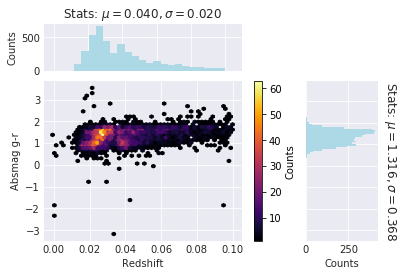

In [16]:
# make a scatter plot
fig, ax, histdata = r.plot('z', 'absmag_g_r')

By default, it will also plot histograms of the column as well.  This can be turned off by setting `with_hist=False`.

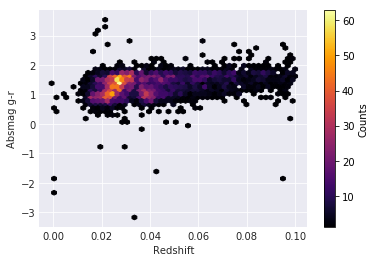

In [17]:
# make only a scatter plot
fig, ax = r.plot('z', 'absmag_g_r', with_hist=False)

We can also quickly plot a histogram of a single column of data using the ``hist`` method, which uses an underlying [hist utility function](https://sdss-marvin.readthedocs.io/en/latest/tools/utils/plot-hist.html).    

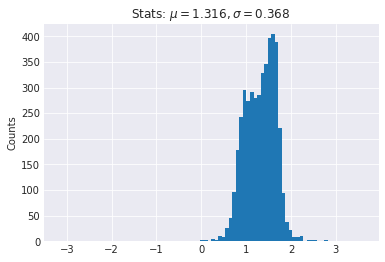

In [18]:
histdata, fig, ax = r.hist('absmag_g_r')

<a id='download'></a>
## Downloading Results
You can download the raw files from your results using the ``download`` method.  This uses the ``downloadList`` utility function under the hood.  By default this will download the DRP cubes for each target row.  It accepts any keyword arguments as ``downloadList``.

In [19]:
# download the DRP datacube files from the results 
# r.download()

## Additional Resoures
- Get a refresher on [Queries](https://sdss-marvin.readthedocs.io/en/latest/query/query.html)
- See more details of what you can do with [Results](https://sdss-marvin.readthedocs.io/en/latest/query/results.html#using-results)
- See the [Results API](https://sdss-marvin.readthedocs.io/en/latest/reference/queries.html#marvin-results-ref) for a look at the Marvin Results object.